In [1]:
# some libraries
library(rjags)
library(dplyr)
library(parallel)

Caricamento del pacchetto richiesto: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs


Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# list of files (lifetime data)
files <- list.files(path = "./2023_24", pattern = "*.dat$", full.names = TRUE)

In [3]:
# function to read the files    
extract_data_from_file <- function(file) { 
  # code to extract data from file 
  data <- readLines(file) 
  # returning as numeric (each line is an integer ADC reading) 
  return(as.numeric(data))
} 

# launching a cluster
cl <- makeCluster(detectCores())
results <- parLapply(cl, files, extract_data_from_file) 
stopCluster(cl) 
  
# data is now inside "results" as a multi-indexed list, so results[[i]] = contents of the i-th file
print(results) 

[[1]]
  [1]  48  82  39  74  72  45 489 183 294 153 722 122 404 182 323 373 113  33
 [19] 290 249  50 164 337 315  55 191 240  47 251  26 335  86  34 139 213 115
 [37]  42 374  48  23  87  65 134 217 128 618 101 208  38 173  37  18 178 183
 [55] 139 200  36  28  44 196 177 126  19  37  63 200 203 232 172 360 280 107
 [73] 317 131  70 114  83  27 116 266 247 183 328  34  87 108 123  28 216 506
 [91] 178  20 162 174 116 198  57  82 216  99 294  61 142  30  26 410  37 283
[109]  18 108 189  78 340 510 254  39 247 189 267 262  83  52 510 715 146  38
[127] 100  13 206 243 492  91  72 100  91 173  53  61  60 266  69 129 147 129
[145] 157 199  99  87 106 170 142 380  31  49  19 270 341  36  68 130 414  38
[163] 157 276 136 671  19  91 218 425 196 290 108 196  37 293 125 104  76  94
[181] 668  23 171 171 213 203  52  27 224 326  92 148 296  29 117 178 225 242
[199] 100 317  62 137  47  38  61

[[2]]
  [1]  14 418 423 101 148 161  83  68 109 164  90 180 637 124 175  94 284  16
 [19] 253 148  32

### Lifetime extraction
#### Intro
The idea is to bin the time-intervals distribution in order to get the number of counts foreach bin. Each muon decay process is independent and it is a Poissonian process. Hence, inside each time-bin, we have a Poisson process. If we name $c_i$ the counts inside the i-th bin, then the likelihood is given by the product of all the likelihoods in each bin, so:

$$
\mathcal{L}(\lbrace c_i \rbrace | \tau) = \prod_{i=1}^{N} \left(e^{-\lambda_i}\cdot\frac{\lambda_i^{c_i}}{c_i!} \right)
$$
where the $\lambda_i$ are the parameters of each poisson distribution inside each bin. In Poisson's, $\lambda$ is the expected value so we might say that while $c_i$ are the counts we measured, $\lambda_i$ are the counts we expect for the i-th bin. Considering the i-th time bin, we have the low and high bounds of that bin named $t_{i,0}$ and $t_{i,1}$.

Since we count the number of muons that undergo decay, if we name $N_\mu(t_{i,0})$ the number of muons before decay and $N_\mu(t_{i,1})$ the number of muons after decay, the number of muons that decayed, that is the $\lambda_i$, is:
$$
\lambda_i = N_\mu(t_{i,0}) - N_\mu(t_{i,1})
$$
and using the law of exponential decay ($N(t) = N_0\cdot e^{-t/\tau}$), we might rewrite this as:
$$
\lambda_i = N_\mu \cdot(\exp{\left(-\frac{t_{i,0}}{\tau}\right)} - \exp{\left(-\frac{t_{i,1}}{\tau}\right)})
$$
#### More formal evaluation of $\lambda_i$
Our data is the time interval between the instant a muon crosses the scintillator pad and the instant the particle produced by its decay traverses it back. So, it is an interval where no processes occurr. It is basically how much we have to wait to observe a decay. This interval is exponentially distributed. So we can write that the probability to observe our measurement $t_i$ is:
$$
    P(t_i|\tau) = \frac{1}{\tau}e^{-t_i/\tau}
$$
Then, we can obtain $\lambda_i$ by computing the integral of this probability density between $t_{i,0}$ and $t_{i,1}$ and multiplying it by $N_\mu$ in order to obtain the number of muons that have decayed and that we can thus expect in the i-th bin as counts:
$$
    \lambda_i = N_\mu \int_{t_{i,0}}^{t_{i,1}} \frac{1}{\tau}e^{-t/\tau} dt = N_\mu \left(e^{-t_{i,0}/\tau} - e^{-t_{i,1}/\tau}\right)
$$
which is exactly the same expression obtained above.

#### BUGS model for lifetime
So our model could be:
$$
   \begin{cases}
    \mathcal{L}(\lbrace c_i \rbrace | \tau) = \prod_{i=1}^{N} \left(e^{-\lambda_i}\cdot\frac{\lambda_i^{c_i}}{c_i!} \right)\\
    \lambda_i = N_\mu \left(e^{-t_{i,0}/\tau} - e^{-t_{i,1}/\tau}\right)
   \end{cases}
$$

which translates into BUGS for jags like this:
```bugs
model {
 # likelihood bin per bin
 for (i in 1:n) {
  lambda[i] <- nmu*(exp(-1*bin_low[i]/tau) - exp(-1*bin_high[i]/tau));
  X[i] ~ dpois(lambda[i]);
 }
 # prior: can investigate which one is the best choice
 tau ~ dgamma(1,1e-4);
 # predicted data
 y ~ dpois(1./tau);
}
```
where $n$ is the number of bins of the count spectrum, $\tau$ is the lifetime of the muon, $X$ are the binned counts.


$X
 [1]   56 2983 2505 2536 2252 2180 1933 1830 1778 1608 1522 1307 1343 1125 1064
[16] 1042  897  878  730  651  650  558  474  471  430  369  358  367  301  263
[31]  243  220  202  174  189  133  179  146  127  115   94  102   85   79   71
[46]   66   63   50   63   39   50   46   36   41   41   36   40   34   28   32
[61]   24   22   29   11   26   15   15   23   14   13   12   10   10   13    7

$bin_low
 [1]  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0  2.2  2.4  2.6  2.8  3.0
[16]  3.2  3.4  3.6  3.8  4.0  4.2  4.4  4.6  4.8  5.0  5.2  5.4  5.6  5.8  6.0
[31]  6.2  6.4  6.6  6.8  7.0  7.2  7.4  7.6  7.8  8.0  8.2  8.4  8.6  8.8  9.0
[46]  9.2  9.4  9.6  9.8 10.0 10.2 10.4 10.6 10.8 11.0 11.2 11.4 11.6 11.8 12.0
[61] 12.2 12.4 12.6 12.8 13.0 13.2 13.4 13.6 13.8 14.0 14.2 14.4 14.6 14.8 15.0

$bin_high
 [1]  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1  3.3  3.5
[16]  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7  5.9  6.1  6.3  6.5
[31]  6.7  6.9  7.1  7.3  7.5  7.7  7.9  8.1  8.3  8.5  8.7  8.9  9.1  9.3  9.5
[46]  9.7  9.9 10.1 10.3 10.5 10.7 10.9 11.1 11.3 11.5 11.7 11.9 12.1 12.3 12.5
[61] 12.7 12.9 13.1 13.3 13.5 13.7 13.9 14.1 14.3 14.5 14.7 14.9 15.1 15.3 15.5

$n
[1] 75

$nmu
[1] 37529

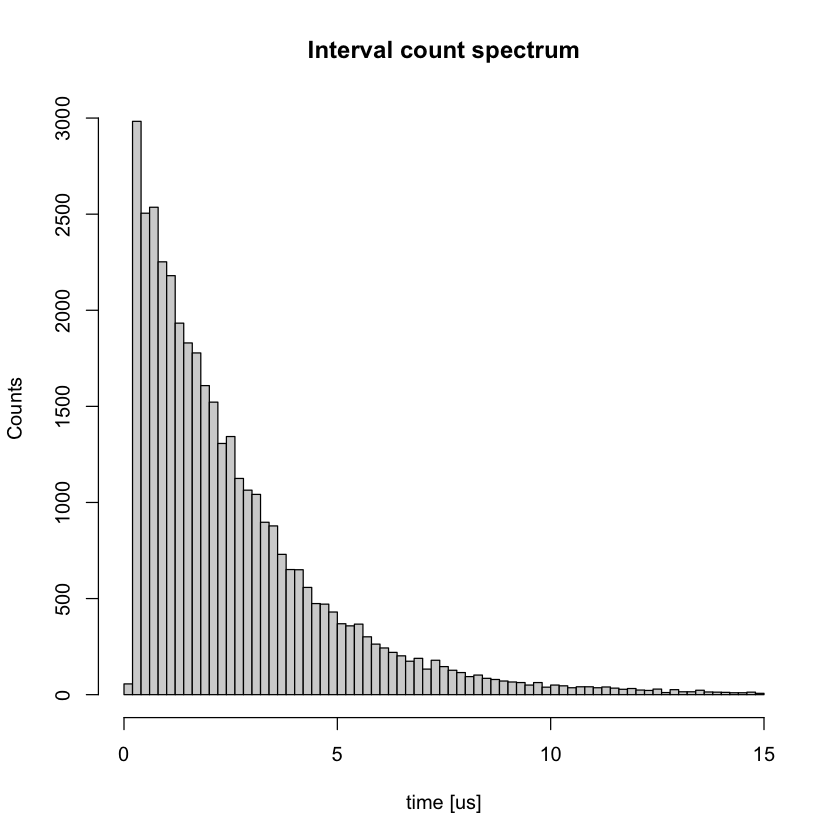

In [4]:
# preparing the dataframe for jags
data <- NULL;
# binning the results in time and obtaining counts
h <- hist((unlist(results)*14.90+7.4)/1000., xlim=c(0,15), breaks=90, xlab="time [us]", ylab="Counts", main="Interval count spectrum")
# assembling the dataframe
data$X <- h$counts
data$bin_low <- h$breaks
data$bin_high <- (h$breaks+0.5)
data$bin_low <- data$bin_low[-1]
data$bin_high <- data$bin_high[-1]
data$n <- length(h$counts)
data$nmu <- length(unlist(results))
data

In [5]:
# building the model
jm <- jags.model("model_test.bug", data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 75
   Unobserved stochastic nodes: 2
   Total graph size: 833

Initializing model



In [6]:
# training
update(jm, 1000)
chain <- coda.samples(jm, c("tau","y"), n.iter=10000)
print(summary(chain))


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD  Naive SE Time-series SE
tau 2.2065 0.01178 0.0001178      0.0001266
y   0.4457 0.67149 0.0067149      0.0069387

2. Quantiles for each variable:

     2.5%   25%   50%   75% 97.5%
tau 2.184 2.199 2.207 2.214  2.23
y   0.000 0.000 0.000 1.000  2.00



In [7]:
# conversion to dataframe
df <- as.data.frame(as.mcmc(chain))

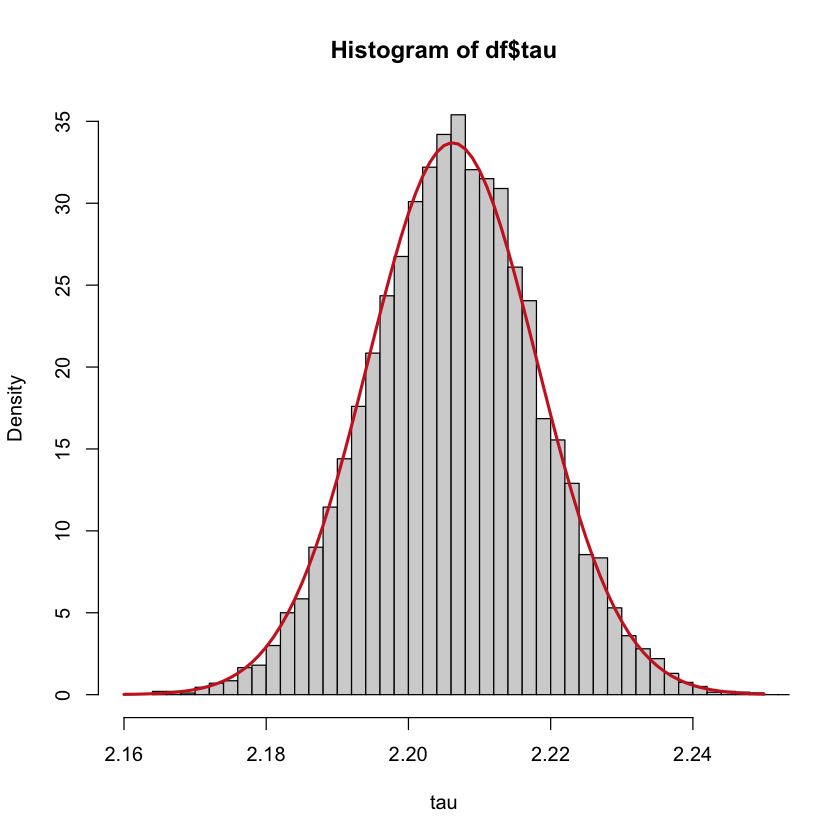

In [8]:
# plotting an histogram for the lifetime tau
x <- seq(from=2.16, to=2.25, by=0.001)
htau <- hist(df$tau, prob=TRUE, ylim=c(0,35), xlim=c(2.16,2.25), breaks=60, xlab="tau")
# overlaying a gaussian distribution centered on the mean obtained by jags
lines(x, dnorm(x, 2.2062, 0.01184), col='firebrick3', lwd=2.5)

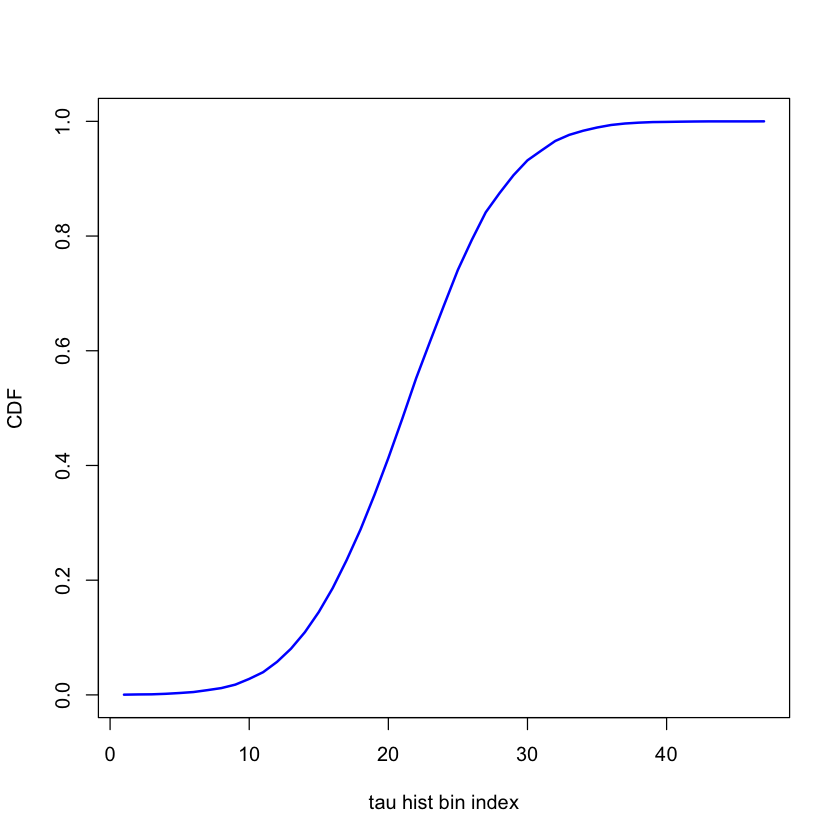

In [9]:
# 95% confidence levels -> building the cumulative distribution
cs <- cumsum(htau$density)/sum(htau$density)
plot(cs, type='l', lty='solid', lwd=2, col='blue', xlab="tau hist bin index", ylab="CDF")

In [10]:
# getting the left and right indexes for the bounds of the 95% interval
idxs_low <- which(cs <= 0.025)
idx_low <- idxs_low[length(idxs_low)]
idxs_high <- which(cs >= 0.975)
idx_high <- idxs_high[1]
idxs_high

[1] 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47

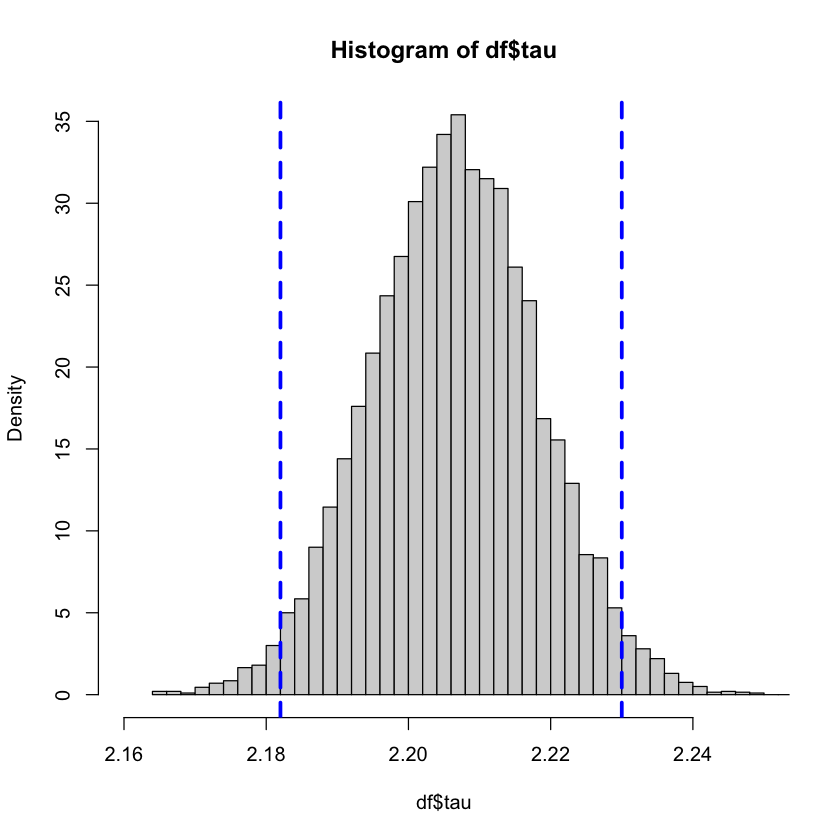

In [11]:
# showing
hist(df$tau, prob=TRUE, ylim=c(0,35), xlim=c(2.16,2.25), breaks=60)
halfbin = (htau$breaks[2]-htau$breaks[1])/2;
abline(v=htau$mids[idx_low] + halfbin, col='blue', lwd=3, lty='dashed')
abline(v=htau$mids[idx_high] + halfbin, col='blue', lwd=3, lty='dashed')

#### Note on binning
The binning on the initial distribution impacts the quality of the results obtained later. We could investigate by producing several estimates of $\tau$ with varying initial binning to check the effect. With 90 bins it seems we obtain a rather good estimate at $(2.2065 \pm 0.0118) \mu s$ compared with the literature $(2.1969811\pm0.0000022)\mu s$, compatibilit is:
$$
C = \frac{\left|\tau_1 - \tau_2\right|}{\sqrt{\sigma_1^2 + \sigma_2^2}} = 0.81
$$